In [ ]:
import torch

import torch.optim as optim
from itertools import chain

from torch.utils.data import DataLoader, TensorDataset, Dataset

from torchsummary import summary
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
import random

random.seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

import torchvision.datasets
import torchvision.transforms as tr

In [ ]:
MNIST_train=torchvision.datasets.MNIST('./', download = True, train = True)
MNIST_test=torchvision.datasets.MNIST('./', download = True, train = False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 35211899.80it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1085192.46it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9700238.02it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9011603.01it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
X_train = MNIST_train.train_data/255
X_test = MNIST_test.train_data/255

X_train=X_train.to(torch.float32)
X_test=X_test.to(torch.float32)

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [ ]:
class Encoder(torch.nn.Module):
    def __init__(self, latent_size):
        super().__init__()

        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1,padding=1)
        self.act1 = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1,padding=1)
        self.act2 = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.linear = torch.nn.Linear(7*7,latent_size)
        self.act3 = torch.nn.ReLU()

        self.fc_mu = torch.nn.Linear(latent_size, latent_size) #формирование вектора мат ожиданий
        self.fc_log_var = torch.nn.Linear(latent_size, latent_size) #формирование вектора логарифма дисперсий

        self.latent_size = latent_size

    def forward(self, x):
        # ВАШ КОД ЗДЕСЬ
        #print("Start", x.size())
        x = self.act1(self.conv1(x))
        #print("Conv1",x.size())
        x = self.pool1(x)
        #print("pool",x.size())
        x = self.act2(self.conv2(x))
        #print('conv2', x.size())
        x = self.pool2(x)
        #print("pool",x.size())

        #x = x.reshape(-1, self.latent_size) #делаем reshape, чтобы из сверточного слоя в полносвязку передать вектора
        #x = torch.flatten(x, start_dim=1)
        x = x.reshape((x.shape[0], -1))

        x = self.act3(self.linear(x))
        #print(x)

        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        return mu, log_var #результат энкодера -- это вектор средних и вектор дисперсий

    def sample_latent(self, x): #получаем вектор скрытого состояния Z
        mu, log_var = self.forward(x) #получае вектора средних и дисперсий
        #print(mu, log_var)

        #torch.randn_like(input) Возвращает тензор случайных чисел из стандартного нормального распределения того же размера, что и input
        N = torch.randn_like(mu).to(device)

        #дисперсия у нас возвращается в логарифме, а умножить нам надо на стандартное отклонение
        #тогда нужно /2, степень уходит и взять экспоненту, получим просто стандартное отклонение
        return torch.exp(log_var/2) * N + mu, mu, log_var

In [ ]:
class Decoder(torch.nn.Module):
    def __init__(self, latent_size):
        super().__init__()

        self.deconv1 = torch.nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=2,stride=2)
        self.act1 = torch.nn.ReLU()
        self.deconv2 = torch.nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=2,stride=2)
        self.act2 = torch.nn.ReLU()
        self.conv = torch.nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3,stride=1,padding=1)
        self.act3 = torch.nn.Sigmoid() # А ПОЧЕМУ??


        self.linear2 = torch.nn.Linear(latent_size, 300)
        self.linear3 = torch.nn.Linear(300,7*7)

    def forward(self, x):


        #print(x.size())
        x = self.act2(self.linear2(x))
        #print(x)
        x = self.act2(self.linear3(x))
        #print(x)
        x = x.reshape((x.shape[0], 7, 7))
        #print(x)


        #print("Start", x.size())
        x = self.act1(self.deconv1(x))
        #print("deconv1",x.size())
        x = self.act3(self.deconv2(x))
        #print("deconv1",x.size())
        x = self.act3(self.conv(x))
        #print("conv",x.size())

        return x


In [ ]:
def train_ae(data_loader, encoder, decoder, epochs, lr, device):
    print('Обучение автокодировщика..')

    encoder.train()
    decoder.train()

    recon_loss_func = torch.nn.MSELoss()

    #kl_loss_func = torch.nn.KLDivLoss(reduction="batchmean")

    def kl_loss_func(mu, logvar):
        return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    optimizer = optim.Adam(chain(encoder.parameters(), decoder.parameters()), lr=lr)

    loss_history = list()
    loss=0
    for epoch in range(epochs):
        for i, batch in enumerate(data_loader):

            optimizer.zero_grad()

            #прямой проход через кодер и получение вектора Z, вектора средних и вектора дисперсий
            latent_vector, mu, log_sigma = encoder.sample_latent(batch)

            #получение ошибки MSE
            #print(latent_vector.size())
            recon_loss = recon_loss_func(decoder(latent_vector), batch)

            #получение ошибки KL
            kl_loss = kl_loss_func(mu, log_sigma)
            loss = kl_loss + 1000 * recon_loss # можно поварьировать балансировочный коэффициент

            #recon_loss.backward()
            #kl_loss.backward()
            loss.backward()
            #print("AAAAAAAAAAAAA", kl_loss)

            optimizer.step()

            #if i % 10000 == 0:
            #    print('Потери восстановления:', recon_loss) #.item()
            #    print('Потери расхождения распределений:', kl_loss)

            loss_history.append(loss.log().item())

        print(f'Эпоха {epoch + 1} / {epochs}. Потери на последнем пакете: {loss.item()}')

    encoder.eval()
    decoder.eval()

    print('Готово!')

    plt.plot(loss_history)
    plt.show()

Обучение автокодировщика..
Эпоха 1 / 10. Потери на последнем пакете: 91.34929656982422
Эпоха 2 / 10. Потери на последнем пакете: 59.46150207519531
Эпоха 3 / 10. Потери на последнем пакете: 64.04937744140625
Эпоха 4 / 10. Потери на последнем пакете: 63.63117980957031
Эпоха 5 / 10. Потери на последнем пакете: 31.426639556884766
Эпоха 6 / 10. Потери на последнем пакете: 74.54393005371094
Эпоха 7 / 10. Потери на последнем пакете: 59.293853759765625
Эпоха 8 / 10. Потери на последнем пакете: 40.334442138671875
Эпоха 9 / 10. Потери на последнем пакете: 44.86417007446289
Эпоха 10 / 10. Потери на последнем пакете: 95.11438751220703
Готово!


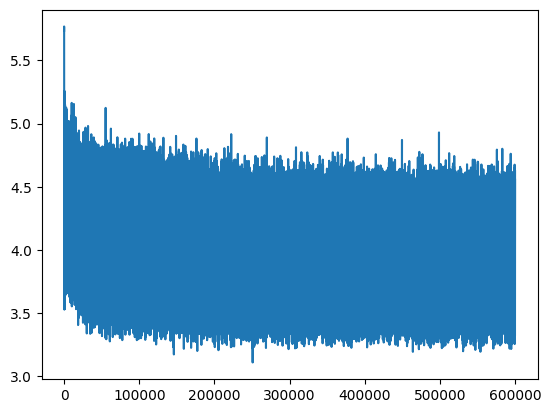

In [ ]:
LATENT_SIZE = 32# размерность скрытого пространства

BATCH_SIZE =256 # ?
EPOCHS = 10# ?
LEARNING_RATE = 0.0001# ?

device = 'cuda' if torch.cuda.is_available() else 'cpu'

#загрузить выбраные данные
#создать dataloader
train_data_loader = DataLoader(X_train.to(device), shuffle=True)#????

encoder = Encoder(LATENT_SIZE).to(device)
decoder = Decoder(LATENT_SIZE).to(device)

train_ae(train_data_loader, encoder, decoder, EPOCHS, LEARNING_RATE, device)

In [ ]:
#сгенерировать новые объекты
#взять вектор из стандартного нормального распределения (torch.randn()) и отравить в декодер

tensor([[-0.6325,  0.4713,  1.0972,  ...,  1.3069, -1.1530,  0.0366],
        [ 0.7715, -0.7638,  0.4547,  ...,  1.1677, -2.3372,  0.2118],
        [ 1.3174,  2.0523,  1.0683,  ...,  3.5773, -0.2123, -1.7293],
        ...,
        [-0.3954,  0.0050, -1.2248,  ...,  0.5090, -1.6978,  0.4947],
        [ 1.4462, -1.2809,  0.3642,  ...,  0.0150, -2.0771, -0.4234],
        [ 1.3748, -0.6769, -1.4560,  ..., -0.0038,  0.7429, -0.5606]],
       device='cuda:0')


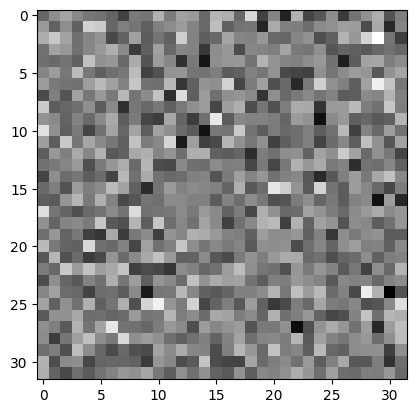

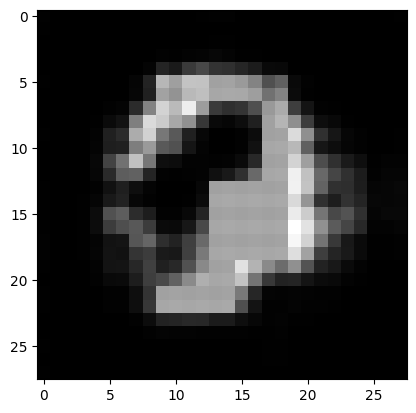

In [ ]:
x = torch.randn(32, 32)
x = x.to(device)
print(x)
samples = decoder(x)
plt.imshow(x.to(torch.device('cpu')).detach().numpy(), cmap='gray')
plt.show()
plt.imshow(samples.to(torch.device('cpu')).detach().numpy()[0], cmap='gray')